## Import Libraries

In [70]:
### Library for hf datasets
import datasets
from icecream import ic
import sys
import os
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import transformers as transformers
import numpy as np
BASE_DIR:Path = Path(os.getcwd())
ROOT_DIR:Path = BASE_DIR.parent

# Let's explore the dataset library

In [2]:
## load the emotions dataset
emotions = datasets.load_dataset("emotion")
## type of emotions dataset
ic(type(emotions))
## structure of the emotions dataset
ic(emotions)
## Each value of the dataset dict is a HuggingFace `Dataset` object
ic(type(emotions['train']))

ic| type(emotions): <class 'datasets.dataset_dict.DatasetDict'>
ic| emotions: DatasetDict({
                  train: Dataset({
                      features: ['text', 'label'],
                      num_rows: 16000
                  })
                  validation: Dataset({
                      features: ['text', 'label'],
                      num_rows: 2000
                  })
                  test: Dataset({
                      features: ['text', 'label'],
                      num_rows: 2000
                  })
              })
ic| type(emotions['train']): <class 'datasets.arrow_dataset.Dataset'>


datasets.arrow_dataset.Dataset

In [3]:

train_ds = emotions['train']
### length of the dataset
ic(len(train_ds))
### Index of the dataset
ic(train_ds[0])
### columns of the dataset
ic(train_ds.column_names)

## Features of the dataset
ic(train_ds.features)

## we can also slice the dataset
ic(train_ds[0:5])

ic| len(train_ds): 16000
ic| train_ds[0]: {'label': 0, 'text': 'i didnt feel humiliated'}
ic| train_ds.column_names: ['text', 'label']
ic| train_ds.features: {'label': ClassLabel(names=['sadness',
                                                   'joy',
                                                   'love',
                                                   'anger',
                                                   'fear',
                                                   'surprise']),
                        'text': Value('string')}
ic| train_ds[0:5]: {'label': [0, 0, 3, 2, 3],
                    'text': ['i didnt feel humiliated',
                             'i can go from feeling so hopeless to so damned hopeful just from '
                             'being around someone who cares and is awake',
                             'im grabbing a minute to post i feel greedy wrong',
                             'i am ever feeling nostalgic about the fireplace i will know that it

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

## loading a custom file to the HF datasets

In [4]:
file_path = BASE_DIR/'my_file.csv'
custom_dataset = datasets.load_dataset('csv', data_files=str(file_path))
custom_dataset['train'][:]

{'text': ['this is a positive sentence',
  'this is a negative sentence',
  'this is a neutral sentence',
  'this is a positive sentence',
  'this is a negative sentence',
  'this is a neutral sentence',
  'this is a positive sentence',
  'this is a negative sentence',
  'this is a neutral sentence'],
 'label': [1, 0, 2, 1, 0, 2, 1, 0, 2]}

## we can change the format of the data to view it in a better way as well
- This only changes the view of the data not how the data is stored

In [5]:
emotions.set_format(type='pandas')
ic(emotions['train'][0:5])

emotions.reset_format()

ic| emotions['train'][0:5]:                                                 text  label
                            0                            i didnt feel humiliated      0
                            1  i can go from feeling so hopeless to so damned...      0
                            2   im grabbing a minute to post i feel greedy wrong      3
                            3  i am ever feeling nostalgic about the fireplac...      2
                            4                               i am feeling grouchy      3


In [6]:
emotions['train'].features['label'].int2str(0)

'sadness'

In [7]:
def add_emotions_text(example):
    example['text_label'] = emotions['train'].features['label'].int2str(example['label'])
    return example

emotions.map(add_emotions_text)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 2000
    })
})

In [8]:
def add_emotions_text_batch(batch):
    ## notice that the return is a dictionary : {key = new feature, value = list}
    processed_batch = {
        'text_label' : [emotions['train'].features['label'].int2str(example['label']) for example in batch ]
    }
    return processed_batch
## return is done much faster
emotions.map(
    add_emotions_text,
    batched = True,
    num_proc=4
    )


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'text_label'],
        num_rows: 2000
    })
})

## Data Analysis

In [9]:
emotions.set_format('pandas')
df = emotions['train'][:]

## add text label to df
def add_text_label(row):
  return emotions['train'].features['label'].int2str(row['label'])

df['label_name'] = df.apply(add_text_label, axis = 1)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


<Axes: xlabel='label_name'>

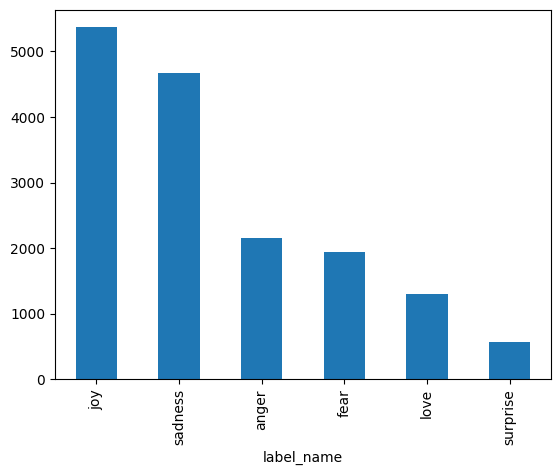

In [10]:
df['label_name'].value_counts().plot(kind = 'bar')

<Axes: xlabel='label_name', ylabel='words_per_tweet'>

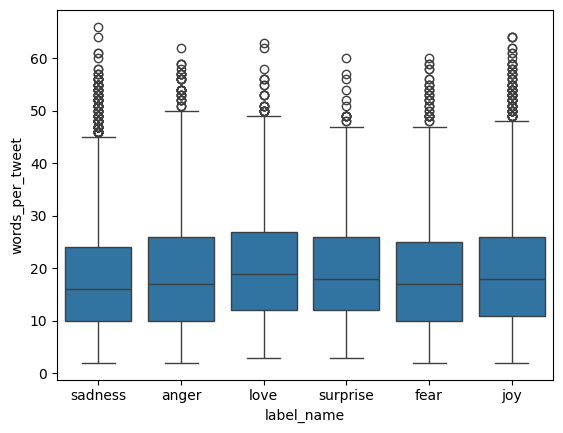

In [11]:
### Length of tweets --> Important because of the token length, defines the context length of the BERT model
df['words_per_tweet'] = df['text'].apply(lambda x: len(x.split(' ')))
## There is no major difference in the tweet length for different emotions
sn.boxplot(data = df, x = 'label_name', y = 'words_per_tweet')

In [12]:
emotions.reset_format()

# Tokenization

Optimal splitting of words into tokens is usually learned from the corpus

## character level tokenization
- Issues: 
    - This takes away the semantic meaning completely
    - Things as simple as words need to be learned from the data. This makes the learning process a lot more complex

In [13]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

## convert each character to integer --> Numericalization
token2idx = {
    t:idx for idx,t in enumerate(list(sorted(set(tokenized_text))))
}
print(f"""
Each unique token maps to an integer now
{token2idx}
""")

## get the actual text coded
input_ids = [token2idx[x] for x in tokenized_text]
print(f"""
The actual text can be encoded as :
{input_ids}
""")

## convert it into one-hot vectors
import torch
import torch.nn.functional as F

one_hot_encodings=  F.one_hot(
    input = torch.tensor(input_ids), num_classes = len(token2idx)
)

print(
    f"""
    {one_hot_encodings.shape=}
    number of rows  = length of tokenized text : {len(tokenized_text)}
    number of columns = length of vocabulary: {len(set(tokenized_text))}
    """)

## Lets take a look at the encoded vector
print(
    f"""
    First alphabet of the tokenized text = {tokenized_text[0]}
    Corresponding Index = {token2idx[tokenized_text[0]]}
    Index with value is 1 for 20 dimensional representation of first character = {torch.where(one_hot_encodings[0]==1)[0].item()}
    """
)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']

Each unique token maps to an integer now
{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


The actual text can be encoded as :
[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


    one_hot_encodings.shape=torch.Size([38, 20])
    number of rows  = length of tokenized text : 38
    number of columns = length of vocabulary: 20
    

    First alphabet of the tokenized text = T
    Corresponding Index = 5
    Index with value is 1 for 20 dimensional representation of first character = 5
    


## Word level tokenizations
- The issue here is that this doesn't account for punctuations. misspellings, etc. The vocabulary size mcan easily grow in this case.
- In case we have a vocabulary of 1M words, Each token will be represented by a 1M dimensional vector. If we want to compress it into a 1000 dimensional vector we would need a matrix multiplier of 1M x 1000  = 1 * 10^9 weights
- A quick fix can be capping the vocabulary size to 10_000 most frequent words and using `<UNK>` as an identifier for other words. This way we will probably loose some information but make the model size more manageable


In [14]:
tokenized_text = text.split()
print(f"""
Tokenizing by word combines punctuation with the NLP and treats 'NLP.' as a token:
{tokenized_text}"""
)


Tokenizing by word combines punctuation with the NLP and treats 'NLP.' as a token:
['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


## Subword Tokenization
- Its a tradeoff between the character level tokenization and word level tokenization
- In this tokenization, 
    - We break the less common words into smaller units so model can deal with misspellings and complex words
    - We keep the common words as is.
- This makes the vocabulary size manageable (no need to account for misspellings etc.) and also enables maintaining the context of the sentence.
- The main feature of subword tokenization is that it is learned from the <B>Pre-training corpus</B> 
- There are a lot of algorithms that can do subword tokenization. BERT and DistilBERT use the <B> WordPiece </B> algorithm

### WordPiece Tokenization
- Developed by Google to pretrain BERT
- Similar to BPE algorithm
    - BPE stands for Byte Pair Encoding
    - More details about the BPE and modification to create wordpiece : https://huggingface.co/learn/llm-course/en/chapter6/6

# Tokenization for DistilBert

In [24]:
## Way 1: To initialize the tokenizer using Auto... class
from transformers import AutoTokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

## Way 2: specific tokenizer
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)
ic(tokenizer, distilbert_tokenizer)

ic| tokenizer: DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
               	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
               	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
               	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
               	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
               	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
               }
           

(DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
 	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 }
 ),
 DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_f

Few observations about tokenization:
1. The regeneration of the tokenized text comes with some special tokens: [CLS], [SEP] etc. These tokens mark the beginning and end of the sequence. 
2. All the tokens are now lower-cased which is an attribute of the checkpoint
3. Uncommon words like tokenizing, NLP have been broken down and prefix '##' is used to indicate this

In [ ]:
## tokenize the text
encoded_text = tokenizer(text)
print(f"""Tokenized text : {encoded_text}""")
## convert tokens back to text
converted_tokens = tokenizer.convert_ids_to_tokens(encoded_text['input_ids'])
print(f"""Converted Tokens : {converted_tokens}""")
converted_string = tokenizer.convert_tokens_to_string(converted_tokens)
print(f"""Converted String : {converted_string}""")

## Some other information that can be obtained from tokenizer

Tokenized text : {'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
Converted Tokens : ['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']
Converted String : [CLS] tokenizing text is a core task of nlp. [SEP]


In [43]:
vocab_size = tokenizer.vocab_size
context_length = tokenizer.model_max_length
model_input_names = tokenizer.model_input_names

print(
    f"""
{vocab_size=}
{context_length=}
Inputs that model accepts as a forward pass : {model_input_names=}
"""
)


vocab_size=30522
context_length=512
Inputs that model accepts as a forward pass : model_input_names=['input_ids', 'attention_mask']



In [58]:
## Padding = True pads the sequence to the maximum size of the input sequence
def mytokenize(batch):
    return tokenizer(batch['text'], padding = True, truncation = True)

mytokenize(emotions['train'][0:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [84]:
## Using map performs opeation on each row and then adds the output to the existing dataset
## Batch size = None ensures that the entire matrix has same size
emotions_tokenized = emotions.map(mytokenize, batched = True, batch_size = None)
emotions_tokenized

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [73]:
np.array(emotions_tokenized['train'][:]['input_ids'])

array([[  101,  1045,  2134, ...,     0,     0,     0],
       [  101,  1045,  2064, ...,     0,     0,     0],
       [  101, 10047,  9775, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  1045,  2514, ...,     0,     0,     0],
       [  101,  1045,  2113, ...,     0,     0,     0]], shape=(16000, 87))